# Traveling Salesman Problem / Optimal Route

The Travelling Salesman Problem (TSP) is a classic optimization problem in which a salesman must visit a set of cities exactly once and return to the starting city, with the goal of minimizing the total travel distance or cost. In the context of linear optimization, TSP can be modeled using integer linear programming (ILP), where binary variables represent whether a particular route between two cities is chosen. Constraints ensure that each city is visited once, and subtour elimination constraints prevent smaller loops within the route. Solving TSP is computationally challenging, especially for larger instances, as it is NP-hard requiring advanced techniques like branch-and-bound or heuristics.

## Problem Formulation
For a city tour, each attraction is listed with it's coordinates. The tour should start at node 1.
Find the shortest path to visit all attractions and return to the starting point. 


### Miller Tucker-Zemlin (MTZ) formulation

Sets:
$$I :  \text{set of nodes/ attractions}$$

Variables:
$$x_{ij} = 
    \begin{cases}
        1 \text{: if the path goes from node i to j} \newline 0 \text{: otherwise} 
    \end{cases}$$
$$u_i \in N : \text{the order position which each node is visited}$$

Parameter:
$$d_{ij} > 0: \text{the distance between node i and node j}$$

  
Objective:  minimize the total distance to visit all nodes/ attractions
$$min_x z = \sum_{i=1}^n \sum_{j \neq  i, j=1}^n d_{ij} x_{ij}$$
subject to:

$$ \begin{gather}  \sum_{i =1, i \neq j}^n x_{ij} = 1 \quad j = 1, \dots , n  \\  
 \sum_{j =1, j \neq i}^n x_{ij} = 1 \quad i = 1, \dots , n  \\
 u_i - u_j + 1 \leq (n-1)(1-x_{ij}) \quad 2 \leq i \neq j \leq n  \\
 2 \leq u_i \leq n \quad 2 \leq i \leq n.\end{gather} $$

explanation: 
1) constraint to enter a city from exactly one other city 
2) constraint to exit each city to exactly one other city
3) constraint to ensure that no "subtours" are created:  
    * when $x_{ij}=1$ (path goes from i to j): $u_i - u_j + 1 <=0$,  i must be visited before j. The "+1" ensures to not accidentally give them the same visit order. 
    * when $x_{ij}=0$ (no path between i and j): no real constraint is set, since the formulation becomes: $u_i - u_j + 1 <= (n-1)$, which will always be satisfied (the visit order difference is much smaller than the number of nodes.)
4) constraint to ensure that each node (except the starting node) will be visited as part of the tour (it gets a number in the order).The visiting number given to each node should be at least 2 but no more than the total number of houses.

In [13]:
import math
import matplotlib.pyplot as plt
import random
from typing import NamedTuple, Self

NUMBER_OF_ATTRACTIONS = 15

class Node(NamedTuple):
    id: int
    x: float
    y: float

    @property
    def node_coordinates(self):
        return (self.x, self.y)
    
    @staticmethod
    def calc_distance(node1: Self, node2: Self) -> float:
        return math.sqrt((node1.x - node2.x) ** 2 + (node1.y - node2.y) ** 2)
    


In [14]:
# generate a number of randomly placed attractions

attractions = [
    Node(id+1, random.random(), random.random()) for id in range(NUMBER_OF_ATTRACTIONS)
]


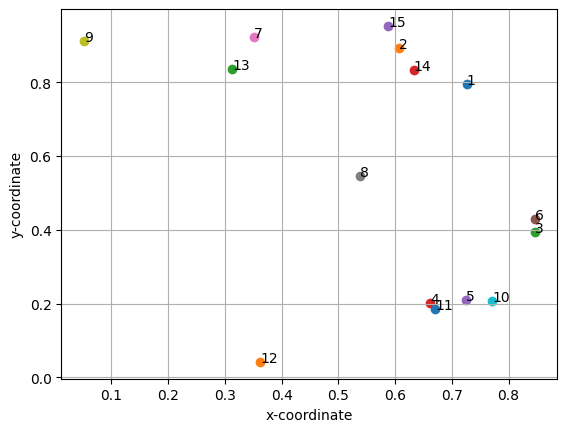

In [15]:

for attraction in attractions:
    plt.scatter(attraction.x, attraction.y)
    plt.text(attraction.x, attraction.y, f"{attraction.id}")

plt.grid(True)
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.show()

In [16]:
attractions

[Node(id=1, x=0.7266177469063669, y=0.7941954883684708),
 Node(id=2, x=0.6073909005791295, y=0.8935834398408656),
 Node(id=3, x=0.8461888362010074, y=0.39282667943249194),
 Node(id=4, x=0.661617386450153, y=0.20170973749294363),
 Node(id=5, x=0.7245191187283011, y=0.210034908751213),
 Node(id=6, x=0.8461147549585858, y=0.4282893034904328),
 Node(id=7, x=0.35138634485813147, y=0.9225141070294324),
 Node(id=8, x=0.5378765855250719, y=0.5463310834243815),
 Node(id=9, x=0.051463410468778115, y=0.9125712394891071),
 Node(id=10, x=0.7713940252630539, y=0.20708562631041627),
 Node(id=11, x=0.6710114540873491, y=0.18618375957346878),
 Node(id=12, x=0.36269134926540847, y=0.04203936380158024),
 Node(id=13, x=0.3129381910517711, y=0.834803507113787),
 Node(id=14, x=0.6328675183870793, y=0.8333888364526004),
 Node(id=15, x=0.5875430174599555, y=0.9524069018708643)]

## Computational Solution with Pyomo

In the following the MTZ is implemented with pyomo and the HIGHS solver, which is a high performance open-source solver (for LP, MIP and quadratic problems). To improve performance, it uses the branch-and-bound approach amongst other techniques. A direct solution in brute-force mode, trying all permutations, would have a time complexity of $O(n!)$.

In [17]:
import pyomo.environ as pyo

n = len(attractions)
print(n)

model = pyo.ConcreteModel()

# Sets
model.nodes = pyo.RangeSet(n)
model.u_set = pyo.RangeSet(2, n)

# Decision Vars
model.x = pyo.Var(model.nodes, model.nodes, within=pyo.Binary)
model.u = pyo.Var(
    model.nodes,
    bounds=(1, n),
    within=pyo.NonNegativeIntegers,
    #initialize={i: i for i in model.nodes_i},
)

# Params
def init_distance(model, i, j):
    node_i = attractions[i-1] # pyomo sets start at 1
    node_j = attractions[j-1]
    return Node.calc_distance(node_i, node_j)

model.distance = pyo.Param(
    model.nodes, model.nodes, initialize=init_distance, mutable=True
)

# Objective
model.total_distance = pyo.Objective(
    expr=sum(
        model.distance[i, j] * model.x[i, j]
        for i in model.nodes
        for j in model.nodes
    ),
    sense=pyo.minimize,
)

# Constraints
def enter_rule(model, i):
    return sum(model.x[i, j] for j in model.nodes if j != i) == 1
model.con1 = pyo.Constraint(model.nodes, rule=enter_rule)


def exit_rule(model, j):
    return sum(model.x[i, j] for i in model.nodes if i != j) == 1
model.con2 = pyo.Constraint(model.nodes, rule=exit_rule)


def u_ascending_order_rule(model, i, j):
    if i != j:
        return model.u[i] - model.u[j] + 1 <= (n - 1) * (1 - model.x[i, j])
    return pyo.Constraint.Skip

model.con3 = pyo.Constraint(model.u_set, model.u_set, rule=u_ascending_order_rule)


def prevent_subtours_rule(model, i):
    return (2, model.u[i], n)  # meaning: 2 <= model.u[i] <= n))


model.con4 = pyo.Constraint(model.u_set, rule=prevent_subtours_rule)


15


In [18]:
optimizer = pyo.SolverFactory("appsi_highs")
result = optimizer.solve(model)

result.write()
print(f"total distance: {pyo.value(model.total_distance)}")
#model.x.display()

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: 3.022858068666293
  Upper bound: 3.022858068666293
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: 1
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Termination message: TerminationCondition.optimal
# ----------------------------------------------------------
#   Solution Information
# ---------------------------------------------------------

In [19]:
edges = {
    i:j for i in model.nodes for j in model.nodes if model.x[i, j].value > 0.5
}

def print_path(edges):
    start_node = 1
    next_node = start_node
    path = [str(next_node)]

    while True:
        next_node = edges[next_node]
        path.append(str(next_node))
        if next_node == start_node:
            break
    print(" -> ".join(path))
    
print_path(edges)

1 -> 14 -> 2 -> 15 -> 7 -> 9 -> 13 -> 8 -> 12 -> 4 -> 11 -> 5 -> 10 -> 3 -> 6 -> 1


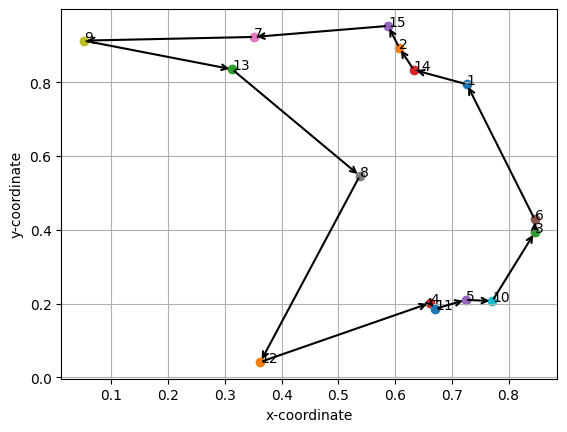

In [20]:
fig, ax = plt.subplots()
    
for node_id, x, y in attractions:
    ax.scatter(x, y)
    ax.text(x, y, f"{node_id}")

# Draw arrows
for i, j in edges.items():
    x_i, y_i = attractions[i-1].node_coordinates
    x_j, y_j = attractions[j-1].node_coordinates
    
    ax.annotate("",
        xy=(x_j, y_j), xycoords='data',
        xytext=(x_i, y_i), textcoords='data',
        arrowprops=dict(arrowstyle="->", color='black', lw=1.5)
    )
    
ax.set_xlabel("x-coordinate")
ax.set_ylabel("y-coordinate")
plt.grid(True)
plt.show()


Resources:
- https://en.wikipedia.org/wiki/Travelling_salesman_problem
- https://medium.com/analytics-vidhya/model-and-solution-of-the-traveling-salesman-problem-with-python-and-pyomo-db45f2631e8c
